In [1]:
import tensorflow as  tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
from pathlib import Path
import shutil
import datetime
from functools import partial

In [2]:
sys.path.append('../utils')

In [3]:
from data_preparing import ChannelData, random_rotation
from model import ChannelCutter, LRFinder
from focal_tversky_loss import *
from cldice_loss import SoftClDice

In [4]:
train_data = ChannelData(
    path=Path('../data/crop_arkansas_512x320_norm/train'),
    elevation='elevation'
)
val_data = ChannelData(
    path=Path('../data/crop_arkansas_512x320_norm/val'),
    elevation='elevation'
)
train_data.add_process(random_rotation)
val_data.add_process(random_rotation)

model = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})


BATCH_SIZE = 2
BUFFER_SIZE = 6

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# bce = weighted_ce_loss
iou = IOULoss(fp_weight=0.5)
loss = iou.loss
# used for model name tagging
session_labels = ['arkansas', 'crop512x320_norm', 'no_rotation', 'iou_fp025']

# first run use fild_lr to find learning rate
find_lr = False

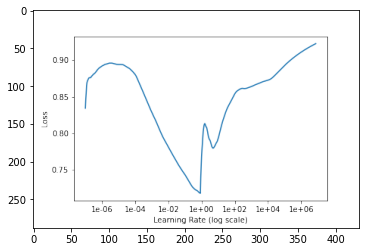

In [5]:
image_name = 'logs/lr_' + '_'.join(session_labels) + '.png'
if find_lr:
    model.compile_model(
        optimizer='adam', 
        loss=loss, 
        metrics=['accuracy']
    )

    lr_finder = LRFinder(start_lr=1e-7, end_lr=10, max_steps=336)
    model.unet.fit(
        train_dataset, epochs=2, 
        callbacks=[lr_finder]
    )
    
    lr_finder.plot()
    plt.savefig(image_name)
else:
    img = mpimg.imread(image_name)
    plt.imshow(img)
    plt.show()

In [6]:
model.unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 320, 4) 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, 512, 320, 32) 6304        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 320, 32) 128         input_conv[0][0]                 
__________________________________________________________________________________________________
pre_unet_conv_step0 (Conv2D)    (None, 512, 320, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.1,
    staircase=True)

model.compile_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss=loss, 
    metrics=['accuracy', tp, tn]
)

session_labels.append('lr1e-3_to_lr1e-4')
session_name = '_'.join(session_labels)
save_path = Path("./logs") / session_name / ('trained_on_'+str(datetime.datetime.now()))
os.makedirs(save_path)
# callback that records training metrics for diagnosis
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=save_path)
# callback that stops training if the monitored metric doesn't improve after specified epochs of training (patience)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_dataset =  train_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_dataset =  val_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.unet.fit(
    train_dataset, epochs=10, validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/10
  1/292 [..............................] - ETA: 0s - loss: 0.9185 - accuracy: 0.6281 - tp: 0.3241 - tn: 0.6351WARNING:tensorflow:From /home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
292/292 [==============================] - 150s 513ms/step - loss: 0.5062 - accuracy: 0.9386 - tp: 0.7069 - tn: 0.9464 - val_loss: 0.6836 - val_accuracy: 0.7654 - val_tp: 0.9322 - val_tn: 0.7603
Epoch 2/10
292/292 [==============================] - 149s 512ms/step - loss: 0.3915 - accuracy: 0.9645 - tp: 0.6802 - tn: 0.9739 - val_loss: 0.4546 - val_accuracy: 0.9688 - val_tp: 0.5158 - val_tn: 0.9833
Epoch 3/10
292/292 [==============================] - 149s 511ms/step - loss: 0.3743 - accuracy: 0.9657 - tp: 0.6978 - tn: 0.9746 - val_loss: 0.4235 - val_accur

## make prediction on original image sizes

In [8]:
import h5py
data_path = Path('../data')
# d1 = h5py.File(data_path / 'TDB_19_4D.mat')

In [9]:
os.listdir(data_path)

['tbd_19_part_1.npy',
 'TDB_19_4D.mat',
 'crop_arkansas_512x320_norm',
 'test_data',
 'crop_512x265',
 'crops',
 'tbd_17_part_0.npy',
 'tbd_17_part_2.npy',
 'RGB_19_2_wet.mat',
 'tbd_17_part_5.npy',
 'tbd_17_part_6.npy',
 'test_output',
 'TDWB_19_2_chanMaps.mat',
 'tbd_19_part_2.npy',
 'TDWB_19_2_SLOPE.mat',
 'tbd_19_part_0.npy',
 'crop_arkansas_512x320',
 'tbd_17_part_3.npy',
 'TDB_17_data.mat',
 'crop_512x320',
 'tbd_17_part_1.npy',
 'tbd_19_part_4.npy',
 'ZD_19_2_wet.mat',
 'crop_512x320_old',
 'tbd_19_part_3.npy',
 'TDB_13_data.mat',
 'tbd_17_part_4.npy']

In [10]:
data = np.load(data_path / 'tbd_17_part_0.npy')

In [11]:
data.shape

(100, 796, 522, 5)

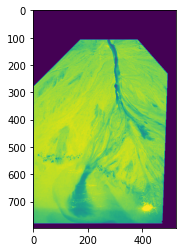

In [12]:
plt.imshow(data[0, :, :, 1])

(array([1.13735e+05, 0.00000e+00, 6.80000e+01, 6.12000e+02, 1.05800e+03,
        8.55000e+03, 2.45500e+04, 6.35830e+04, 1.66082e+05, 3.72740e+04]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

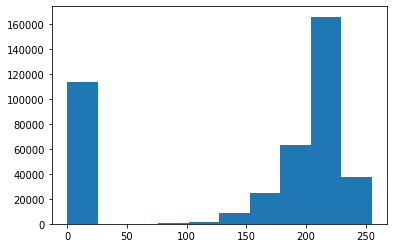

In [13]:
plt.hist(data[0, :, :, 1].ravel())

In [14]:
data[data==0] = np.nan

In [15]:
r_dim, g_dim, b_dim, e_dim, m_dim = 0, 1, 2, 3, 4
channel_dim = -1

In [16]:
one_image = data[0, :, :, 0]
mask = np.all(np.isnan(one_image), axis=1)
# mask2 = np.all(np.isnan(one_image), axis=0)
# trim_data2 = data[:, ~mask, :, :][:, :, ~mask2, :]
trim_data2 = data[:, ~mask, :, :]
trim_data2[:-1][np.isnan(trim_data2[:-1])] = 0
trim_data2[-1][np.isnan(trim_data2[-1])] = -50

In [17]:
trim_data2.shape

(100, 671, 522, 5)

In [18]:
from model import split_process_stitch_images

%reload_ext autoreload
%autoreload 2

In [19]:
def process_one(img_id, trim_data2, process, dims):
    r_dim, g_dim, b_dim, e_dim, m_dim = dims
    # for img_id in range(trim_data2.shape[-1]):
    test_image = trim_data2[img_id, :, :, [r_dim, g_dim, b_dim, e_dim]]
    test_mask = trim_data2[img_id, :, :, m_dim]

    # if channel_dim == 0:
    test_image = np.moveaxis(test_image, 0, -1)
    test_image = np.moveaxis(test_image, 0, 1)
    test_mask = np.moveaxis(test_mask, 0, 1)

#     process = model.unet.predict

    return test_image, test_mask, split_process_stitch_images(test_image, 512, 320, process)

In [20]:
def process_batch(img_ids, trim_data2, process, dims):
    xs, ys, preds = [], [], []
    for img_id in img_ids:
        x, y, pred = process_one(img_id, trim_data2, process, dims)
        xs.append(x)
        ys.append(y)
        preds.append(pred)
        
    return xs, ys, preds

In [21]:
def display_comparison(xs, ys, preds):
    assert len(xs) == len(ys)
    assert len(xs) == len(preds)
    
    n_rows = len(xs)
    fig, axs = plt.subplots(ncols=3, nrows=n_rows, figsize=(18, 6*(n_rows-1)))
    for i_row in range(n_rows):
        axs[i_row][0].imshow(ys[i_row])
        axs[i_row][1].imshow(xs[i_row][:, :, :3].astype(int))
        axs[i_row][2].imshow(preds[i_row])

In [22]:
xs, ys, preds = process_batch([0, 5, 10, 20, 40], trim_data2, model.unet.predict, range(5))

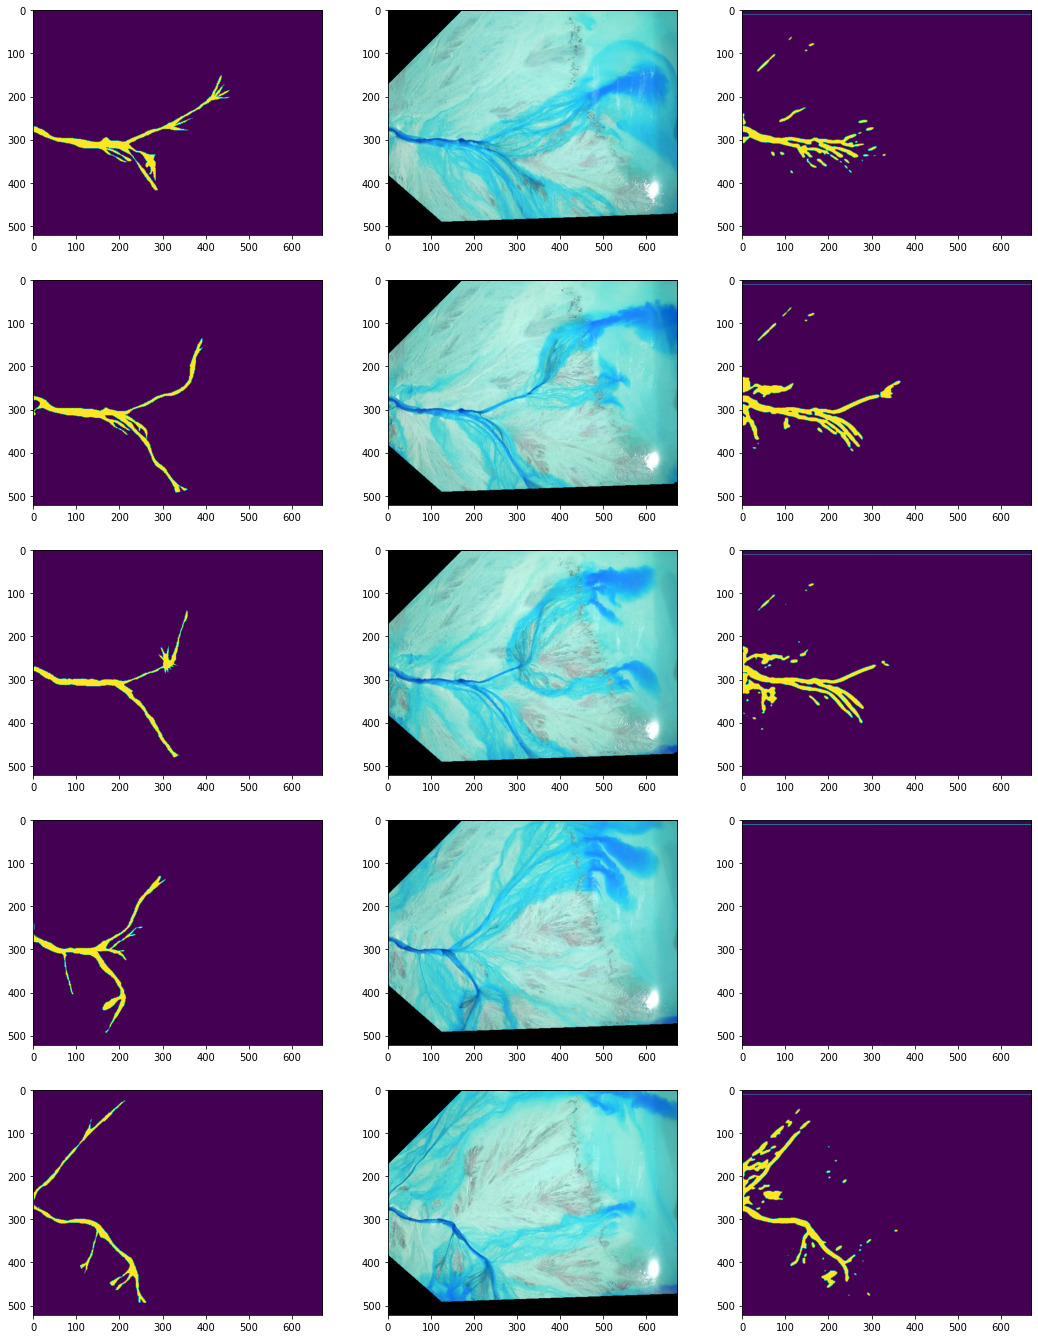

In [23]:
display_comparison(xs, ys, preds)

In [32]:
sxs = tf.image.per_image_standardization(xs[0][:,:,:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


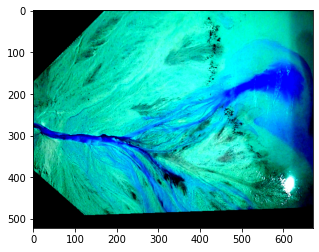

In [33]:
plt.imshow(sxs)

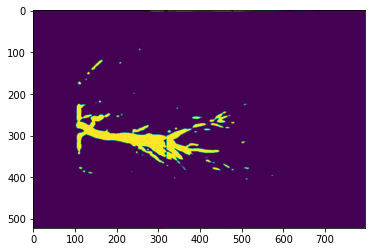

In [53]:
plt.imshow(pred)

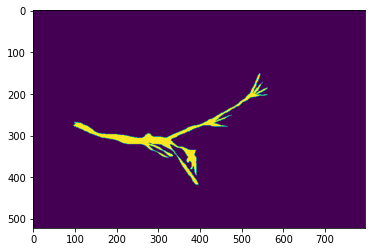

In [54]:
plt.imshow(y)

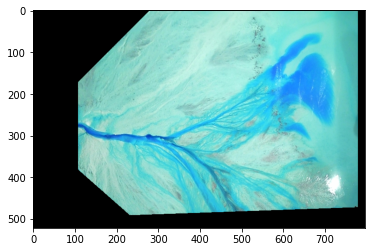

In [55]:
plt.imshow(x[:, :, :3].astype(int))

## save model

In [24]:
import json

In [25]:
with open(save_path / 'model_config.json', 'w') as fp:
    fp.write(str(model.unet.get_config()))

In [26]:
model_path = str(save_path).replace('logs', 'models')
os.makedirs(model_path)

In [27]:
save_path

PosixPath('logs/arkansas_crop512x320_norm_no_rotation_iou_fp025_lr1e-3_to_lr1e-4/trained_on_2021-01-21 23:03:35.875537')

In [14]:
class SaveFigCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        self.save_path = save_path
        self.image_counter = 0
        super().__init__()
        
    def on_predict_batch_end(self, batch, logs=None):
        for img in batch:
            self.image_counter += 1
            tf.keras.preprocessing.image.save_img(
                self.save_path / ('image_' + str(self.image_counter) + '.png'),
                img
            )


In [16]:
model.unet.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/arkansas_crop512x320_no_rotation_iou_fp025_lr1e-3_to_lr1e-4/trained_on_2020-12-30 21:37:07.648899/assets


In [28]:
model_path = str(save_path).replace('logs', 'weights')
os.makedirs(model_path)

In [29]:
model.unet.save_weights(model_path)

In [36]:
model2 = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})
# model2.compile_model(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
#     loss=loss, 
#     metrics=['accuracy', tp, tn]
# )

In [37]:
model2.unet.load_weights(model_path)

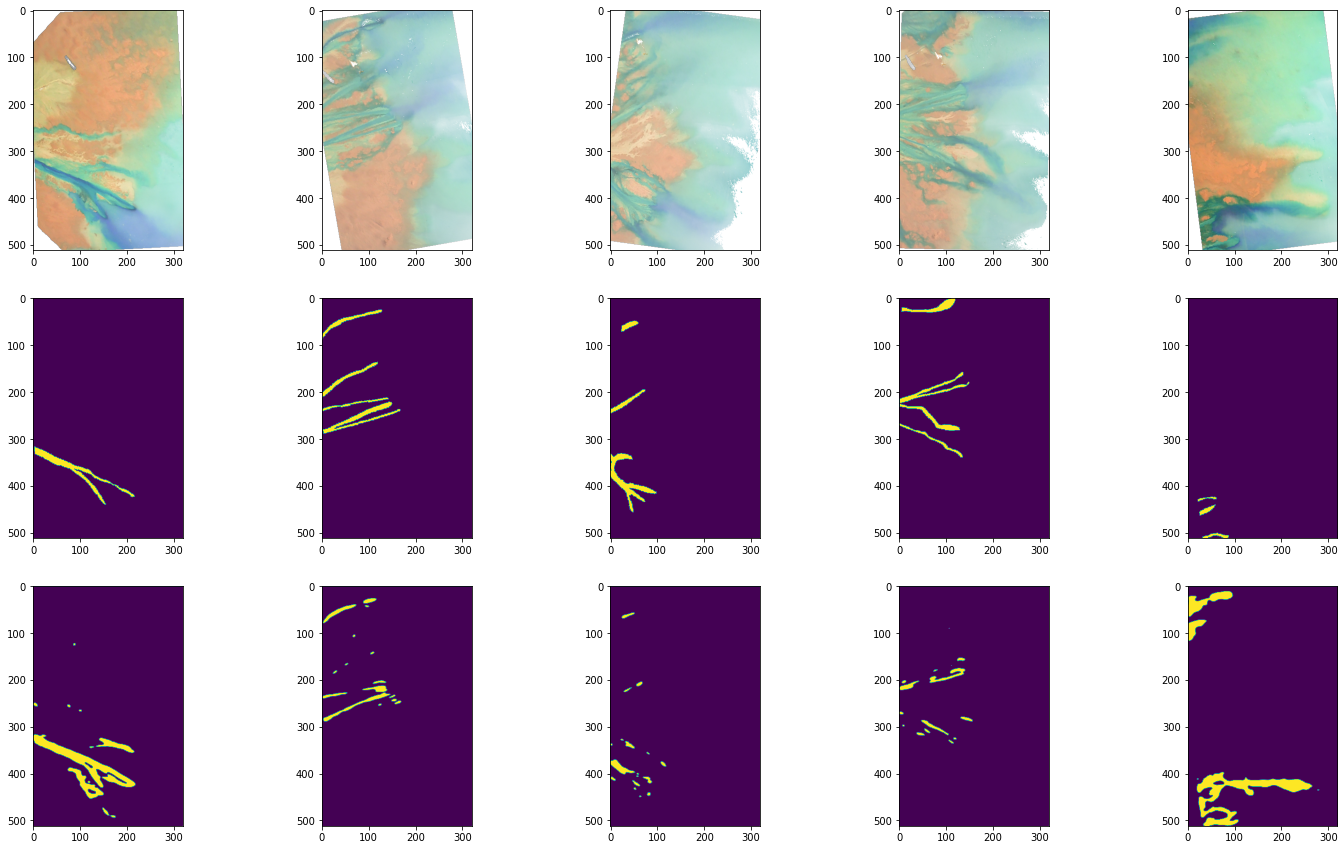

In [38]:
n_samples = 5

fig, axes = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples*5, 15))
i = 0
tf.random.set_seed(2)
for x, y in val_dataset.take(5):
    axes[0][i].imshow(x[0, :, : :])
    axes[1][i].imshow(y[0, :, : :])
    axes[2][i].imshow(model2.unet.predict(x)[0, :, :, 1])
    i += 1

plt.show()
# plt.savefig(save_path / 'example_vals_1.png')

In [19]:
x.shape

TensorShape([2, 512, 320, 4])

(array([ 41228.,   1247.,   9426.,  14792.,  36666.,  61352.,  91627.,
        135688.,  71191.,  28303.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

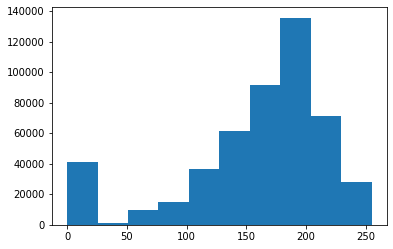

In [21]:
plt.hist(x[0, :, :, :3].numpy().ravel())

(array([ 7619.,     0.,     0.,  4259., 21672.,  9690.,  7549., 26412.,
        55232., 31407.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

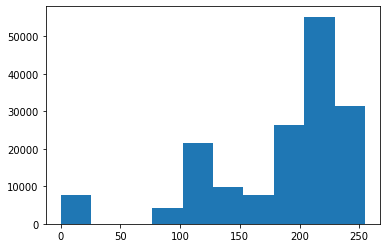

In [67]:
plt.hist(x[0, :, :, 3].numpy().ravel())

In [81]:
import PIL.Image as Image

In [82]:
test_crop_image = Image.open('../data/crop_arkansas_512x320/train/part_0_pass_0_batch_0_num_0_image.png')

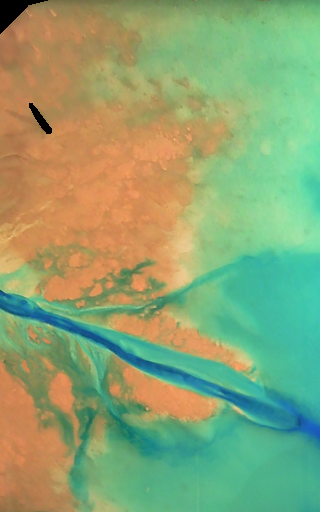

In [83]:
test_crop_image

## save all predictions to files

In [25]:
def save_predictions(dataset, save_path):
    i = 0
    for x, y in dataset.batch(1):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        axes[0].imshow(x[0, :, :, :3])
        axes[1].imshow(x[0, :, :, 3])
        axes[2].imshow(y[0, :, : :])
        axes[3].imshow(model.unet.predict(x)[0, :, :, 1])
        i += 1
        plt.savefig(save_path / f'vals_{str(i)}.png')
        plt.close()

In [26]:
save_predictions(val_data.data, save_path)